In [1]:
# (no of inputs + no of outputs)^0.5 + (1 to 10). 
# to fix the constant value (last part, 0 to 10), 
#use trial and error and find the optimal no of hidden layer neurons for the min MSE.

In [2]:
13 **0.5 +5

8.60555127546399

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
%matplotlib inline


In [4]:
#DATA preprocessing
#Load dataset
x_data = pd.read_csv(r'C:\Users\chongs\BDANALYSIS\furnace_bd.csv')
x_data = x_data.iloc[:,2:]
#epoch time 수정
x_data['3'] = x_data['3'].astype(str).str[:-3].astype(np.int64)
x_data['3'] = x_data['3'].astype(str).str[4:].astype(np.int64)

In [5]:
#구간 선택
x_data = x_data[x_data['3'].values > 890472]
x_data = x_data[x_data['3'].values < 901000]

In [6]:
#pivot table 사용 query 진행
x_data = x_data.pivot_table(index = x_data['3'],columns = x_data['1'])
#dataframe 재설정
x_data = x_data['2'][['temp_zone7_10', 'temp_zone7_12', 'temp_zone7_14', 'temp_zone7_16', 'temp_zone7_4', 'temp_zone7_6', 'temp_zone7_8', 'temp_zone7_top', 'temp_zone8_25', 'temp_zone8_27', 'temp_zone8_29', 'temp_zone8_31', 'temp_zone8_33', 'temp_zone8_35', 'temp_zone8_37', 'temp_zone8_top']]
x_data = x_data.interpolate()

In [7]:
y_data = pd.read_csv(r"C:\Users\chongs\BDANALYSIS\14_Gls_org.csv", engine = 'python', index_col = False)
#원하는 columns 선택

y_data['time'] = y_data['날짜'] + ' ' + y_data['시간']

#시간 delay 수정 및 epoch 시간으로 convert
total_delay = dt.timedelta(minutes = 8, seconds=5)

y_data['time']=(pd.to_datetime(y_data['time']) - total_delay).apply(dt.datetime.timestamp).astype(np.int64)
y_data['time'] = y_data['time'].astype(str).str[4:].astype(np.int64)

y_data = y_data[['time','A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O']]

y_data.set_index('time', inplace = True)


In [8]:
# X, Y data의 index를 y_data의 인덱스에 맞춰 Join 실행(NaN 값 : drop)
xy = pd.concat([x_data, y_data], axis=1, join='inner', join_axes = [x_data.index] )
xy.dropna(inplace=True)

In [9]:
#x,y값 재추출
x = xy[['temp_zone7_10', 'temp_zone7_12', 'temp_zone7_14', 'temp_zone7_16',
       'temp_zone7_6', 'temp_zone7_8','temp_zone8_25', 'temp_zone8_27', 'temp_zone8_29', 'temp_zone8_31',
       'temp_zone8_33', 'temp_zone8_35']].values
y = xy[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O']].values
# y = xy[['H']].values

In [10]:
# Train / Test set 나누기
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=100)

C:\Users\chongs\Anaconda3\envs\mypython\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)

In [17]:
X_train

array([[1.11811783, 1.11909859, 1.00895636, ..., 1.56014947, 1.28170021,
        1.42088715],
       [0.35815343, 0.35935265, 0.19703105, ..., 0.8232973 , 0.57142861,
        0.58326571],
       [1.11811783, 1.11909859, 1.00895636, ..., 0.8232973 , 0.57142861,
        0.58326571],
       ...,
       [1.11811783, 1.11909859, 1.17134143, ..., 1.56014947, 1.18023284,
        1.42088715],
       [1.11811783, 1.11909859, 1.00895636, ..., 1.7075199 , 1.48463495,
        1.42088715],
       [0.35815343, 0.35935265, 0.19703105, ..., 0.8232973 , 0.95193125,
        0.58326571]])

In [13]:
len(y_train)

564

[[0.5189853  0.654647   0.59804    ... 0.39384007 0.56286544 0.26427934]
 [0.5189853  0.654647   0.59804    ... 0.39384007 0.56286544 0.26427934]
 [0.33457422 0.9206155  0.7490387  ... 0.24209407 0.37214765 0.5960575 ]
 ...
 [0.33457422 0.9206155  0.7490387  ... 0.24209407 0.37214765 0.5960575 ]
 [0.33457422 0.9206155  0.7490387  ... 0.24209407 0.3721477  0.5960575 ]
 [0.5189853  0.654647   0.59804    ... 0.39384007 0.56286544 0.26427934]]
MSE: 0.670688
-5.386190399697093


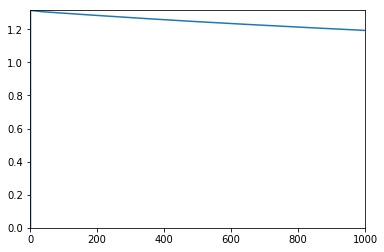

In [20]:
import tensorflow as tf
from sklearn.metrics import r2_score

# layer parameters
n_nodes_hl1 = 9
n_nodes_hl2 = 9
n_nodes_hl3 = 9
no_features = 12
learning_rate = 0.01
epochs = 1000
y_label = y_train.shape[1]


cost_history = np.empty(shape=[1], dtype=float)


X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# defining weights for each layer taken from a normal distribution with variance 2/n
hl1_weight = tf.Variable(tf.random_normal([no_features, n_nodes_hl1], -1.0, 1.0))
hl2_weight = tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2],-1.0,1.0))
hl3_weight = tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3],-1.0, 1.0))
output_weight = tf.Variable(tf.random_normal([n_nodes_hl2, y_label]))

# defining biases for each layer
hl1_bias = tf.Variable(tf.random_uniform([n_nodes_hl1], -1.0, 1.0))
hl2_bias = tf.Variable(tf.random_uniform([n_nodes_hl2], -1.0, 1.0))
hl3_bias = tf.Variable(tf.random_uniform([n_nodes_hl3], -1.0, 1.0))
output_bias = tf.Variable(tf.random_uniform([y_label], -1.0, 1.0))

# defining activation functions for each layer
hl1 = tf.nn.relu(tf.matmul(X, hl1_weight) + hl1_bias)
hl2 = tf.nn.relu(tf.matmul(hl1, hl2_weight) + hl2_bias)
hl3 = tf.nn.relu(tf.matmul(hl2, hl3_weight) + hl3_bias)
output = tf.sigmoid(tf.matmul(hl3, output_weight) + output_bias)

# using mean squared error cost function
cost  = tf.reduce_mean(tf.square(output - Y))

# using Gradient Descent algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


init = tf.global_variables_initializer()

# running the network
with tf.Session() as sess:
    sess.run(init)

    for step in np.arange(epochs):
        sess.run(optimizer, feed_dict={X:X_train, Y:y_train})
        if sess.run(cost, feed_dict={X:X_train, Y:y_train})%10 == 0 :
            print (sess.run(cost, feed_dict={X:X_train, Y:y_train}))
        cost_history = np.append(cost_history, sess.run(cost,feed_dict={X:X_train, Y:y_train}))

    pred_y = sess.run(output, feed_dict={X:X_test})
    print (sess.run(output, feed_dict={X:X_test}))
    mse = tf.reduce_mean(tf.square(pred_y - y_test))
    print("MSE: %4f" % sess.run(mse))
    print(r2_score(y_test, pred_y))
    

    

# # Launch graph
# with tf.Session() as sess:
#     # tensorboard --logdir=./logs/xor_logs
#     merged_summary = tf.summary.merge_all()
#     writer = tf.summary.FileWriter(r"C:\Users\chongs\tensorflow\./logs/xor_logs_r0_01")
#     writer.add_graph(sess.graph)  # Show the graph

#     # Initialize TensorFlow variables
#     sess.run(tf.global_variables_initializer())

#     for step in range(10001):
#         summary, _ = sess.run([merged_summary, optimizer], feed_dict={X: X_train, Y: y_train})
#         writer.add_summary(summary, global_step=step)

#         if step % 100 == 0:
#             print(step, sess.run(cost, feed_dict={
#                   X: x_data, Y: y_data}), sess.run([W1, W2]))

#     # Accuracy report
#     h, c, a = sess.run([hypothesis, predicted, accuracy],
#                        feed_dict={X: x_data, Y: y_data})
#     print("\nHypothesis: ", h, "\nCorrect: ", c, "\nAccuracy: ", a)
 



# plotting the cost history
plt.plot(range(len(cost_history)), cost_history)
plt.axis([0, epochs, 0, np.max(cost_history)])
plt.show()

In [ ]:
https://github.com/rajatgupta310198/Machine_Learning/blob/master/Deep%20Learning/yah.py



def neural_net_model(X_data,input_dim):
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.tanh(layer_1)

    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.tanh(layer_2)

    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2,W_O), b_O)

    return output,W_O

xs = tf.placeholder("float")
ys = tf.placeholder("float")

output,W_O = neural_net_model(xs,3)

cost = tf.reduce_mean(tf.square(output-ys))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

c_t = []
c_test = []


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    saver = tf.train.Saver()
    y_t = denormalize(df_train,y_train)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.xlabel('Days')
    plt.ylabel('Stock Value INR')
    plt.title('Nify Stock Index Prediction')
    ax.plot(range(len(y_train)), y_t,label='Original')
    plt.ion()

    #saver.restore(sess,'yahoo_dataset.ckpt')
    for i in range(100):
        #sess.run([cost,train],feed_dict={xs:X_train, ys:y_train})
        for j in range(X_train.shape[0]):
            sess.run([cost,train],feed_dict={xs:X_train[j,:].reshape(1,3), ys:y_train[j]})

        try:
            ax.lines.remove(lines[0])
        except Exception:
            pass
        pred = sess.run(output, feed_dict={xs:X_train})
        pred = denormalize(df_train,pred)
        lines = ax.plot(range(len(y_train)), pred,'r-',label='Prediction')
        plt.legend(loc='best')
        plt.pause(0.1)

        c_t.append(sess.run(cost, feed_dict={xs:X_train,ys:y_train}))
        c_test.append(sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
        print('Epoch :',i,'Cost :',c_t[i])

    pred = sess.run(output, feed_dict={xs:X_test})
    for i in range(y_test.shape[0]):
        print('Original :',y_test[i],'Predicted :',pred[i])

    #plt.plot(range(50),c_t)
    #plt.plot(range(50),c_test)
    #plt.show()

    print('Cost :',sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
    y_test = denormalize(df_test,y_test)
    pred = denormalize(df_test,pred)
    plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
    plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    """plt.ylabel('Stock Value')
    plt.xlabel('Days')
    plt.title('Stock Market Nifty')"""
    #plt.show()
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() + '/yahoo_dataset.ckpt')
        print('Model Saved')